# Variational Quantum Singular Value Decomposition

<em> Copyright (c) 2021 Institute for Quantum Computing, Baidu Inc. All Rights Reserved. </em>

> **Disclaimer:**  
> This code is based on the original implementation from the Baidu Institute for Quantum Computing's Quantum library.  
> It has been **modified for research and comparison purposes**. The core logic and structure are preserved, but some parts have been adapted to fit the requirements of this project.  
> All original copyrights and credits remain with the original authors.
>

## Overview

In this tutorial, we will go through the concept of classical singular value decomposition (SVD) and the quantum neural network (QNN) version of variational quantum singular value decomposition (VQSVD) [1]. The tutorial consists of the following two parts: 
- Decompose a randomly generated $8\times8$ complex matrix; 
- Apply SVD on image compression.

## Background

Singular value decomposition (SVD) has many applications, including principal component analysis (PCA), solving linear equations and recommender systems. The main task is formulated as following:
> Given a complex matrix $M \in \mathbb{C}^{m \times n}$, find the decomposition in form $M = UDV^\dagger$, where $U_{m\times m}$ and $V^\dagger_{n\times n}$ are unitary matrices, which satisfy the property $UU^\dagger = VV^\dagger = I$.

- The column vectors $|u_j\rangle$ of the unitary matrix $U$ are called left singular vectors $\{|u_j\rangle\}_{j=1}^{m}$ form an orthonormal basis. These column vectors are the eigenvectors of the matrix $MM^\dagger$.
- Similarly, the column vectors $\{|v_j\rangle\}_{j=1}^{n}$ of the unitary matrix $V$ are the eigenvectors of $M^\dagger M$ and form an orthonormal basis.
- The diagonal elements of the matrix $D_{m\times n}$ are singular values $d_j$ arranged in a descending order.

For the convenience, we assume that the $M$ appearing below are all square matrices. Let's first look at an example: 

$$
M = 2*X\otimes Z + 6*Z\otimes X + 3*I\otimes I = 
\begin{bmatrix} 
3 &6 &2 &0 \\
6 &3 &0 &-2 \\
2 &0 &3 &-6 \\
0 &-2 &-6 &3 
\end{bmatrix}, \tag{1}
$$

Then the singular value decomposition of the matrix can be expressed as:

$$
M = UDV^\dagger = 
\frac{1}{2}
\begin{bmatrix} 
-1 &-1 &1 &1 \\
-1 &-1 &-1 &-1 \\
-1 &1 &-1 &1 \\
1 &-1 &-1 &1 
\end{bmatrix}
\begin{bmatrix} 
11 &0 &0 &0 \\
0 &7 &0 &0 \\
0 &0 &5 &0 \\
0 &0 &0 &1 
\end{bmatrix}
\frac{1}{2}
\begin{bmatrix} 
-1 &-1 &-1 &-1 \\
-1 &-1 &1 &1 \\
-1 &1 &1 &-1 \\
1 &-1 &1 &-1 
\end{bmatrix}. \tag{2}
$$

Import packages.

In [1]:
import numpy as np
from numpy import pi as PI
from matplotlib import pyplot as plt
from scipy.stats import unitary_group
from scipy.linalg import norm

import paddle
from paddle_quantum.ansatz import Circuit
from paddle_quantum.linalg import dagger

c:\Users\franc\Documents\UNIVERSIDAD\INVESTIGACION\QSVCD\VQSVD-Project\.venv38\lib\site-packages\setuptools\command\easy_install.py:41: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources
c:\Users\franc\Documents\UNIVERSIDAD\INVESTIGACION\QSVCD\VQSVD-Project\.venv38\lib\site-packages\pkg_resources\__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('mpl_toolkits')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
c:\Users\franc\Documents\UNIVERSIDAD\INVESTIGACION\QSVCD\VQSVD-Project\.venv38\lib\site-packages\pkg_resources\__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified

In [2]:
# Draw the learning curve in the optimization process
def loss_plot(loss):
    '''
    loss is a list, this function plots loss over iteration
    '''
    plt.plot(list(range(1, len(loss)+1)), loss)
    plt.xlabel('iteration')
    plt.ylabel('loss')
    plt.title('Loss Over Iteration')
    plt.show()

## Classical Singular Value Decomposition

With the above mathematical definition, one can realize SVD numerically through NumPy.

In [3]:
# Generate matrix M
def M_generator():
    I = np.array([[1, 0], [0, 1]])
    Z = np.array([[1, 0], [0, -1]])
    X = np.array([[0, 1], [1, 0]])
    Y = np.array([[0, -1j], [1j, 0]])
    M = 2 *np.kron(X, Z) + 6 * np.kron(Z, X) + 3 * np.kron(I, I)
    return M.astype('complex64')

print('The matrix M we want to decompose is: ')
print(M_generator())

The matrix M we want to decompose is: 
[[ 3.+0.j  6.+0.j  2.+0.j  0.+0.j]
 [ 6.+0.j  3.+0.j  0.+0.j -2.+0.j]
 [ 2.+0.j  0.+0.j  3.+0.j -6.+0.j]
 [ 0.+0.j -2.+0.j -6.+0.j  3.+0.j]]


In [4]:
# We only need the following line of code to complete SVD
U, D, V_dagger = np.linalg.svd(M_generator(), full_matrices=True)


# Print decomposition results
print("The singular values of the matrix from large to small are:")
print(D)
print("The decomposed unitary matrix U is:")
print(U)
print("The decomposed unitary matrix V_dagger is:")
print(V_dagger)

The singular values of the matrix from large to small are:
[11.  7.  5.  1.]
The decomposed unitary matrix U is:
[[-0.5+0.j -0.5+0.j  0.5+0.j  0.5+0.j]
 [-0.5+0.j -0.5+0.j -0.5+0.j -0.5+0.j]
 [-0.5+0.j  0.5+0.j -0.5+0.j  0.5+0.j]
 [ 0.5+0.j -0.5+0.j -0.5+0.j  0.5+0.j]]
The decomposed unitary matrix V_dagger is:
[[-0.5+0.j -0.5+0.j -0.5+0.j  0.5+0.j]
 [-0.5+0.j -0.5+0.j  0.5+0.j -0.5+0.j]
 [-0.5+0.j  0.5+0.j  0.5+0.j  0.5+0.j]
 [-0.5+0.j  0.5+0.j -0.5+0.j -0.5+0.j]]


In [5]:
# Then assemble it back, can we restore the original matrix?
M_reconst = np.matmul(U, np.matmul(np.diag(D), V_dagger))
print(M_reconst)

[[ 3.+0.j  6.+0.j  2.+0.j  0.+0.j]
 [ 6.+0.j  3.+0.j  0.+0.j -2.+0.j]
 [ 2.+0.j  0.+0.j  3.+0.j -6.+0.j]
 [ 0.+0.j -2.+0.j -6.+0.j  3.+0.j]]


Surely, we can be restored the original matrix $M$! One can further modify the matrix, see what happens if it is not a square matrix.

---

## Quantum Singular Value Decomposition

Next, let's take a look at what the quantum version of singular value decomposition is all about. In summary, we transform the problem of matrix factorization into an optimization problem with the variational principle of singular values. Specifically, this is achieved through the following four steps:

- Prepare an orthonormal basis $\{|\psi_j\rangle\}$, one can take the computational basis $\{ |000\rangle, |001\rangle,\cdots |111\rangle\}$ (this is in the case of 3 qubits)
- Prepare two parameterized quantum neural networks $U(\theta)$ and $V(\phi)$ to learn left/right singular vectors respectively
- Use quantum neural network to estimate singular values $m_j = \text{Re}\langle\psi_j|U(\theta)^{\dagger} M V(\phi)|\psi_j\rangle$
- Design the loss function $\mathcal{L}(\theta)$ and use PaddlePaddle Deep Learning framework to maximize the following quantity, 

$$
L(\theta,\phi) = \sum_{j=1}^T q_j\times \text{Re} \langle\psi_j|U(\theta)^{\dagger} MV(\phi)|\psi_j\rangle. \tag{3}
$$

Where $q_1>\cdots>q_T>0$ is the adjustable weights (hyperparameter), and $T$ represents the rank we want to learn or the total number of singular values to be learned.



### Case 1: Decompose a randomly generated $8\times8$ complex matrix

Then we look at a specific example, which can better explain the overall process.

In [6]:
# First fix the random seed, in order to reproduce the results at any time
np.random.seed(42)

# Set the number of qubits, which determines the dimension of the Hilbert space
N = 3

# Make a random matrix generator
def random_M_generator():
    M = np.random.randint(10, size = (2**N, 2**N)) + 1j*np.random.randint(10, size = (2**N, 2**N))
    return M

M = random_M_generator()
M_err = np.copy(M)


# Output the matrix M
print('The matrix M we want to decompose is:')
print(M)

# Apply SVD and record the exact singular values
U, D, V_dagger = np.linalg.svd(M, full_matrices=True)
print("The singular values of the matrix M are:")
print(D)

The matrix M we want to decompose is:
[[6.+1.j 3.+9.j 7.+3.j 4.+7.j 6.+6.j 9.+8.j 2.+7.j 6.+4.j]
 [7.+1.j 4.+4.j 3.+7.j 7.+9.j 7.+8.j 2.+8.j 5.+0.j 4.+8.j]
 [1.+6.j 7.+8.j 5.+7.j 1.+0.j 4.+7.j 0.+7.j 9.+2.j 5.+0.j]
 [8.+7.j 0.+2.j 9.+2.j 2.+0.j 6.+4.j 3.+9.j 8.+6.j 2.+9.j]
 [4.+8.j 2.+6.j 6.+8.j 4.+7.j 8.+1.j 6.+0.j 1.+6.j 3.+6.j]
 [8.+7.j 1.+4.j 9.+2.j 8.+7.j 9.+5.j 4.+2.j 1.+0.j 3.+2.j]
 [6.+4.j 7.+2.j 2.+0.j 0.+4.j 3.+9.j 1.+6.j 7.+6.j 3.+8.j]
 [1.+9.j 5.+9.j 5.+2.j 9.+6.j 3.+0.j 5.+3.j 1.+3.j 9.+4.j]]
The singular values of the matrix M are:
[54.83484985 19.18141073 14.98866247 11.61419557 10.15927045  7.60223249
  5.81040539  3.30116001]


In [7]:
# Hyperparameter settings
RANK = 8       # Set the number of rank you want to learn
ITR = 100   # Number of iterations
LR = 0.02   # Learning rate
SEED = 14   # Random seed

# Set the learning weight 
weight = np.arange(3 * RANK, 0, -3).astype('complex128')
print('The selected weight is:')
print(weight)

The selected weight is:
[24.+0.j 21.+0.j 18.+0.j 15.+0.j 12.+0.j  9.+0.j  6.+0.j  3.+0.j]


We design QNN with the following structure:

In [8]:
# Set circuit parameters
num_qubits = 3              # number of qubits
cir_depth = 20              # circuit depth

In [9]:
# Define quantum neural network
def U_theta(num_qubits: int, depth: int) -> Circuit:

    # Initialize the network with Circuit
    cir = Circuit(num_qubits)
    
    # Build a hierarchy：
    for _ in range(depth):
        cir.ry()
        cir.rz()
        cir.cnot()

    return cir

Then we complete the main part of the algorithm:

In [10]:
class VQSVD():
    def __init__(self, matrix: np.ndarray, weights: np.ndarray, num_qubits: int, depth: int, rank: int, lr: float, itr: int, seed: int):
        
        # Hyperparameters
        self.rank = rank
        self.lr = lr
        self.itr = itr
        
        paddle.seed(seed)
        
        # Create the parameter theta for learning U
        self.cir_U = U_theta(num_qubits, depth)
        
        # Create a parameter phi to learn V_dagger
        self.cir_V = U_theta(num_qubits, depth)
        
        # Convert Numpy array to Tensor supported in Paddle
        self.M = paddle.to_tensor(matrix)
        self.weight = paddle.to_tensor(weights)

    # Define the loss function
    def loss_func(self):
        
        # Get the unitary matrix representation of the quantum neural network
        U = self.cir_U.unitary_matrix()
        V = self.cir_V.unitary_matrix()
    
        # Initialize the loss function and singular value memory
        loss = paddle.to_tensor(0.0)
        singular_values = np.zeros(self.rank)
        
        # Define loss function
        for i in range(self.rank):
            loss -= paddle.real(self.weight)[i] * paddle.real(dagger(U) @ self.M @ V)[i][i]
            singular_values[i] = paddle.real(dagger(U) @ self.M @ V)[i][i].numpy()
        
        # Function returns learned singular values and loss function
        return loss, singular_values
    
    def get_matrix_U(self):
        return self.cir_U.unitary_matrix()
    
    def get_matrix_V(self):
        return self.cir_V.unitary_matrix()
    
    # Train the VQSVD network
    def train(self):
        loss_list, singular_value_list = [], []
        optimizer = paddle.optimizer.Adam(learning_rate=self.lr, parameters=self.cir_U.parameters()+self.cir_V.parameters())
        for itr in range(self.itr):
            loss, singular_values = self.loss_func()
            loss.backward()
            optimizer.minimize(loss)
            optimizer.clear_grad()
            loss_list.append(loss.numpy()[0])
            singular_value_list.append(singular_values)
            if itr% 10 == 0:
                print('iter:', itr,'loss:','%.4f'% loss.numpy()[0])
                
        return loss_list, singular_value_list

c:\Users\franc\Documents\UNIVERSIDAD\INVESTIGACION\QSVCD\VQSVD-Project\.venv38\lib\site-packages\paddle\fluid\framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif dtype == np.bool:
c:\Users\franc\Documents\UNIVERSIDAD\INVESTIGACION\QSVCD\VQSVD-Project\.venv38\lib\site-packages\paddle\fluid\dygraph\math_op_patch.py:276: UserWarning: The dtype of left and right variables are not the same, left dtype is paddle.float32, but right dtype is paddle.float64, the right dtype will convert to paddle.float32
  warnings.warn(


iter: 0 loss: -88.4530
iter: 10 loss: -1795.0785
iter: 20 loss: -2059.0496
iter: 30 loss: -2202.6445
iter: 40 loss: -2269.9841
iter: 50 loss: -2304.1877
iter: 60 loss: -2320.8438
iter: 70 loss: -2331.9180
iter: 80 loss: -2340.2454
iter: 90 loss: -2348.0540


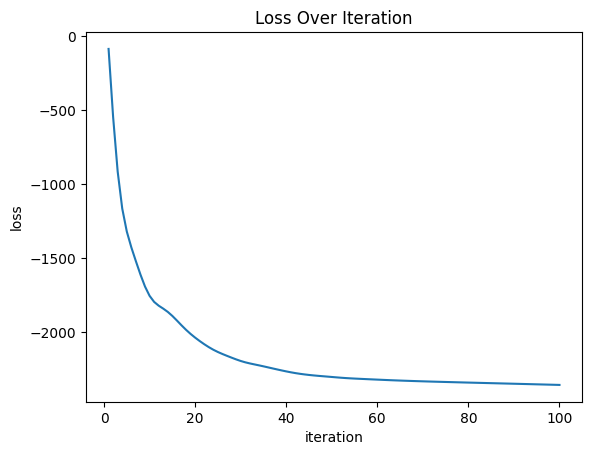

In [11]:
# Record the optimization process
loss_list, singular_value_list = [], []
U_learned, V_dagger_learned = [], []

# Construct the VQSVD network and train
net = VQSVD(matrix=M, weights=weight, num_qubits=num_qubits, depth=cir_depth, rank=RANK, lr=LR, itr=ITR, seed=SEED)
loss_list, singular_value_list = net.train()

# Draw a learning curve
loss_plot(loss_list)

# Record the last two learned unitary matrices
U_learned = net.get_matrix_U().numpy()
V_dagger_learned = dagger(net.get_matrix_V()).numpy()

We now explore the accuracy of the quantum version of singular value decomposition. In the above section, we mentioned that the original matrix can be expressed with less information obtained by decomposition. Specifically, it uses the first $T$ singular values and the first $T$ left and right singular vectors to reconstruct a matrix:

$$
M_{re}^{(T)} = UDV^{\dagger}, \tag{4}
$$

For matrix $M$ with rank $r$, the error will decreasing dramatically as more and more singular values are used to reconstruct it. The classic singular value algorithm can guarantee:

$$
\lim_{T\rightarrow r} ||M-M_{re}^{(T)}||^2_2 = 0, \tag{5}
$$

The distance measurement between the matrices is calculated by the Frobenius-norm,

$$
||M||_2 = \sqrt{\sum_{i,j} |M_{ij}|^2}. \tag{6}
$$

The current quantum version of singular value decomposition still needs a lot of efforts to be optimized. In theory, it can only guarantee the reduction of accumulated errors.

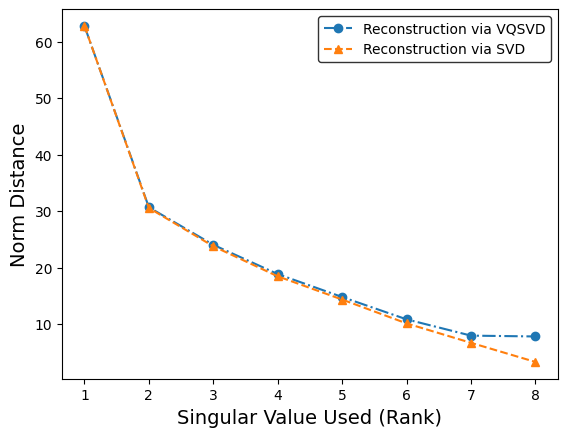

In [12]:
singular_value = singular_value_list[-1]
err_subfull, err_local, err_SVD = [], [], []
U, D, V_dagger = np.linalg.svd(M, full_matrices=True)


# Calculate the Frobenius-norm error
for i in range(RANK):
    lowrank_mat = np.matrix(U[:, :i]) * np.diag(D[:i])* np.matrix(V_dagger[:i, :])
    recons_mat = np.matrix(U_learned[:, :i]) * np.diag(singular_value[:i])* np.matrix(V_dagger_learned[:i, :])
    err_local.append(norm(lowrank_mat - recons_mat)) 
    err_subfull.append(norm(M_err - recons_mat))
    err_SVD.append(norm(M_err- lowrank_mat))


# Plot
fig, ax = plt.subplots()
ax.plot(list(range(1, RANK+1)), err_subfull, "o-.", 
        label = 'Reconstruction via VQSVD')
ax.plot(list(range(1, RANK+1)), err_SVD, "^--", 
        label='Reconstruction via SVD')
plt.xlabel('Singular Value Used (Rank)', fontsize = 14)
plt.ylabel('Norm Distance', fontsize = 14)
leg = plt.legend(frameon=True)
leg.get_frame().set_edgecolor('k')

---
### Case 2: Image compression

In order to fulfill image processing tasks, we first import the necessary package.



In [13]:
# Image processing package PIL
from PIL import Image

# Open the picture prepared in advance
img = Image.open('./figures/MNIST_32.png')
imgmat = np.array(list(img.getdata(band=0)), float)
imgmat.shape = (img.size[1], img.size[0])
imgmat = np.matrix(imgmat)/255

FileNotFoundError: [Errno 2] No such file or directory: 'c:\\Users\\franc\\Documents\\UNIVERSIDAD\\INVESTIGACION\\QSVCD\\VQSVD-Project\\app\\algorithms\\figures\\MNIST_32.png'

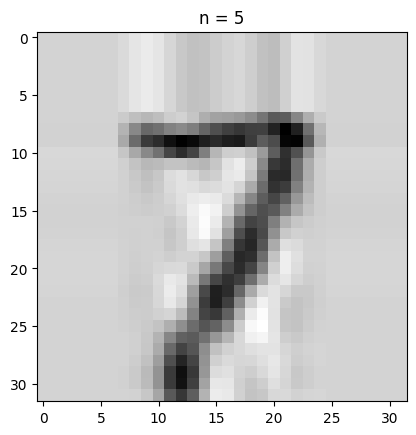

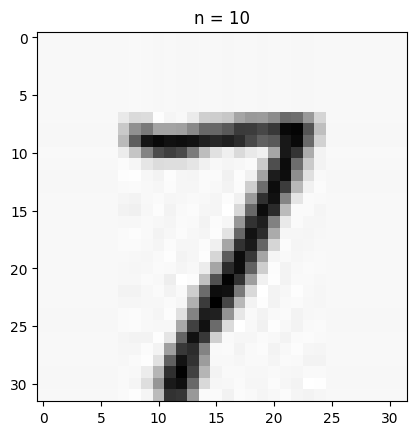

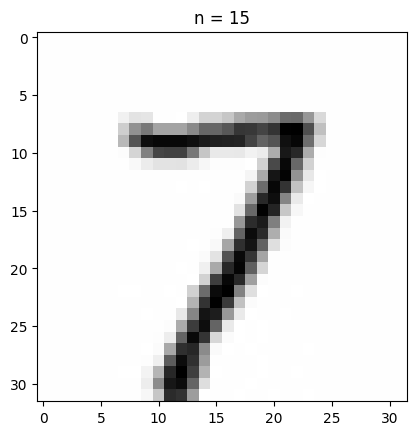

In [ ]:
# Then we look at the effect of the classic singular value decomposition
U, sigma, V = np.linalg.svd(imgmat)

for i in range(5, 16, 5):
    reconstimg = np.matrix(U[:, :i]) * np.diag(sigma[:i]) * np.matrix(V[:i, :])
    plt.imshow(reconstimg, cmap='gray')
    title = f"n = {i}"
    plt.title(title)
    plt.show()

In [ ]:
# Set circuit parameters
cir_depth = 40      # depth of circuit
num_qubits = 5      # Number of qubits

# Hyper-parameters
RANK = 8            # Set the number of rank you want to learn
ITR = 200           # Number of iterations
LR = 0.02           # Learning rate
SEED = 14           # Random number seed

# Set the learning weight
weight = np.arange(2 * RANK, 0, -2).astype('complex128')

# Convert the image into numpy array
def Mat_generator():
    imgmat = np.array(list(img.getdata(band=0)), float)
    imgmat.shape = (img.size[1], img.size[0])
    lenna = np.matrix(imgmat)
    return lenna.astype('complex128')

M_err = Mat_generator()
U, D, V_dagger = np.linalg.svd(Mat_generator(), full_matrices=True)

In [ ]:
# Define circuit of quantum neural network
def U_theta(num_qubits: int, depth: int) -> Circuit:

    # Initialize the network with Circuit
    cir = Circuit(num_qubits)
    
    # Build a hierarchy：
    for _ in range(depth):
        cir.ry()
        cir.cnot()

    return cir

iter: 0 loss: 3902.6995
iter: 10 loss: -109068.0078
iter: 20 loss: -124662.9766
iter: 30 loss: -136021.7500
iter: 40 loss: -143259.4688
iter: 50 loss: -147684.3906
iter: 60 loss: -150412.6406
iter: 70 loss: -151939.6250
iter: 80 loss: -152878.9375
iter: 90 loss: -153509.0000
iter: 100 loss: -153973.1094
iter: 110 loss: -154308.6875
iter: 120 loss: -154568.3750
iter: 130 loss: -154789.7500
iter: 140 loss: -154995.2969
iter: 150 loss: -155195.5938
iter: 160 loss: -155394.9531
iter: 170 loss: -155593.8750
iter: 180 loss: -155790.8594
iter: 190 loss: -155982.7656


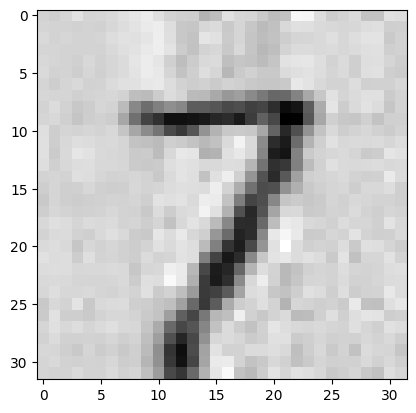

In [ ]:
# Record the optimization process
loss_list, singular_value_list = [], []
U_learned, V_dagger_learned = [], []
    
# Construct the VQSVD network and train
net = VQSVD(matrix=Mat_generator(), weights=weight, num_qubits=num_qubits, depth=cir_depth, rank=RANK, lr=LR, itr=ITR, seed=SEED)
loss_list, singular_value_list = net.train()

# Record the last two unitary matrices learned
U_learned = net.get_matrix_U().numpy()
V_dagger_learned = dagger(net.get_matrix_V()).numpy()

singular_value = singular_value_list[-1]
mat = np.matrix(U_learned.real[:, :RANK]) * np.diag(singular_value[:RANK])* np.matrix(V_dagger_learned.real[:RANK, :])

reconstimg = mat
plt.imshow(reconstimg, cmap='gray')

_______

## References

[1] Wang, X., Song, Z., & Wang, Y. Variational Quantum Singular Value Decomposition. [Quantum, 5, 483 (2021).](https://quantum-journal.org/papers/q-2021-06-29-483/)